In [1]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc
import openmc.deplete
from matplotlib import pyplot

In [2]:
fuel = openmc.Material(name='uo2')
fuel.add_element('U',1, percent_type = "ao", enrichment=19.75)
fuel.add_element('O',2)
fuel.set_density("g/cc",10.5)
fuel.depletable = True

clad_in = openmc.Material(name='graphite')
clad_in.add_element('C',1.0)
clad_in.set_density("g/cm3",1.5)
clad_in.add_s_alpha_beta('c_Graphite')
clad_in.depletable = False

clad_out = openmc.Material(name='SiC')
clad_out.add_element('C',.5)
clad_out.add_element('Si',.5)
clad_out.set_density("g/cm3",2.58)
clad_out.add_s_alpha_beta('c_Graphite')
clad_out.depletable = False

naoh = openmc.Material(name='NaOH')
naoh.set_density("g/cm3", 1.76)
naoh.add_nuclide('Na23', 0.57478656, 'wo')
naoh.add_nuclide('O16',  0.39984656, 'wo')
naoh.add_nuclide('O17',  0.00016150, 'wo')
naoh.add_nuclide('H1',   0.02519782, 'wo')
naoh.add_nuclide('H2',   0.00000755, 'wo')


lioh = openmc.Material(name='LiOH')
lioh.set_density("g/cm3", 1.39)
lioh.add_nuclide('Li6', 0.00001251904, 'wo')
lioh.add_nuclide('Li7', 0.2929339,'wo')
lioh.add_nuclide('O16', 0.6657193, 'wo')
lioh.add_nuclide('O17', 0.0002688907, 'wo')
lioh.add_nuclide('H1',  0.04195279, 'wo')
lioh.add_nuclide('H2',  0.00001257524, 'wo')

coolant = openmc.Material.mix_materials([lioh, naoh], [.24562, .75438],'vo')
coolant.set_density("g/cc", 1.670)
                    
moderator = openmc.Material(name='graphite')
moderator.add_element('C',1.0)
moderator.set_density("g/cc",1.5)
moderator.add_s_alpha_beta('c_Graphite')
moderator.depletable = False

e_moderator = openmc.Material(name='graphite')
e_moderator.add_element('C',1.0)
e_moderator.set_density("g/cc",1.5)
e_moderator.add_s_alpha_beta('c_Graphite')
e_moderator.depletable = False

materials = openmc.Materials([fuel,clad_in,clad_out,coolant,moderator,e_moderator])
materials.export_to_xml()

/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/material.py:740: UserWarning: A uranium enrichment of 19.75 was given for Material ID="1". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


In [3]:
r_fuel   = 0.35
r_clad_1 = 0.5
r_clad_2 = 0.6

r_pt_in  = 7.5 #inner radius of the graphite pressure tube
r_pt_out = 8.5 #outer radius of the graphite pressure tube

lattice_pitch = 18

H= 132.25 #core height in cm
D= 185.35 #core diameter in cm

ring_radii = np.array([0.0, 2.1, 4.2, 6.2])

surf_fuel = openmc.model.RightCircularCylinder((0,0,-H/2),H,r_fuel)

surf_clad_1 = openmc.model.RightCircularCylinder((0,0,-H/2),H,r_clad_1)
surf_clad_2 = openmc.model.RightCircularCylinder((0,0,-H/2),H,r_clad_2)

surf_pt_1 = openmc.model.RightCircularCylinder((0,0,-H/2),H,r_pt_in)
surf_pt_2 = openmc.model.RightCircularCylinder((0,0,-H/2),H,r_pt_out)

In [4]:
radial_surf = [openmc.model.RightCircularCylinder((0,0,-H/2),H,r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

coolant_cells = []
for i in range(ring_radii.size):
    if i == 0:
        coolant_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        coolant_region = +radial_surf[i-1] & -surf_pt_1
    else:
        coolant_region = +radial_surf[i-1] & -radial_surf[i]

    coolant_cells.append(openmc.Cell(fill=coolant, region=coolant_region))

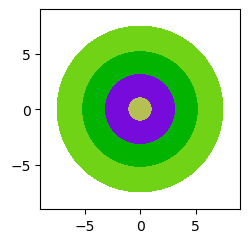

In [5]:
plot_args = {'width':(lattice_pitch,lattice_pitch)}
bundle_universe = openmc.Universe(cells=coolant_cells)
bundle_universe.plot(**plot_args)

In [6]:
coolant_cells[0-4].temperature = 973

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
fuel_cell.temperature = 1473

clad_cell_1 = openmc.Cell(fill=clad_in, region=+surf_fuel & -surf_clad_1)
clad_cell_1.temperature = 1273

clad_cell_2 = openmc.Cell(fill=clad_out, region=+surf_clad_1 & -surf_clad_2)
clad_cell_2.temperature = 973

pin_universe = openmc.Universe(cells=(fuel_cell,clad_cell_1,clad_cell_2))

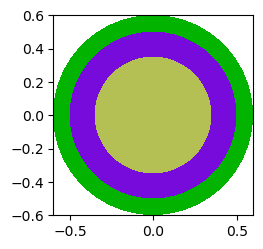

In [7]:
pin_universe.plot(**{'width':(2*r_clad_2,2*r_clad_2)})

In [8]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        theta = (a + j/n*360)*pi/180.
        x = r*cos(theta)
        y = r*sin(theta)

        pin_boundary = openmc.ZCylinder(x0=x,y0=y,r=r_clad_2)
        coolant_cells[i].region &= +pin_boundary

        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

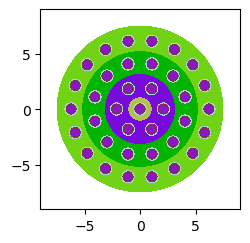

In [9]:
bundle_universe.plot(**plot_args)

In [10]:
lattice_boundary = openmc.model.RectangularParallelepiped(-lattice_pitch/2,lattice_pitch/2,-lattice_pitch/2,lattice_pitch/2,-H/2,H/2)

pt=openmc.Cell(fill=clad_in, region= +surf_pt_1 & -surf_pt_2)
pt.temperature = 973

bundle_universe.add_cell(pt)
moderator_cell=openmc.Cell(fill=moderator, region=-lattice_boundary & +surf_pt_2)
moderator_cell.temperature = 973

bundle_universe.add_cell(moderator_cell)

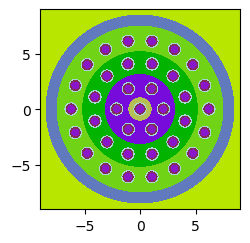

In [11]:
bdu=bundle_universe
bdu.plot(**plot_args)

In [12]:
external_moderator=openmc.Cell(fill=e_moderator, region=-lattice_boundary)
emu = openmc.Universe(cells=[external_moderator])

In [13]:
core_body = openmc.model.RightCircularCylinder((0,0,-H/2),H,D/2, boundary_type='vacuum')

N_assy = 9
CL = openmc.RectLattice(); #Core Lattice
CL.center = (0.,0.)
CL.dimension = [N_assy,N_assy];
CL.lower_left = [-N_assy/2.*lattice_pitch,-N_assy/2.*lattice_pitch]
CL.pitch= [lattice_pitch,lattice_pitch]
CL.universes = [
    [emu,emu,bdu,bdu,bdu,bdu,bdu,emu,emu],
    [emu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,emu],
    [bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu],
    [bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu],
    [bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu],
    [bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu],
    [bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu],
    [emu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,emu],    
    [emu,emu,bdu,bdu,bdu,bdu,bdu,emu,emu]
]
CL.outer=emu

C = openmc.Universe();
core_cell = openmc.Cell();
core_cell.region = -core_body;
core_cell.fill = CL;
C.add_cell(core_cell);

In [14]:
geometry = openmc.Geometry(C)
geometry.export_to_xml()

materials=openmc.Materials(geometry.get_all_materials().values())
materials.export_to_xml()

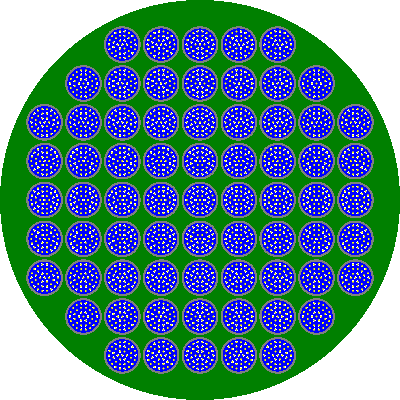

In [15]:
plot = openmc.Plot.from_geometry(geometry)
#plot.basis='yz'
#plot.origin=(7,0,0)
plot.color_by = 'material'
plot.colors = {
    fuel: 'yellow',
    clad_in: 'grey',
    clad_out: 'white',
    coolant: 'blue',
    moderator: 'green',
    e_moderator: 'green',
}
plot.to_ipython_image()

In [16]:
settings = openmc.Settings()
settings.particles = 100000
settings.batches = 100
settings.inactive = 15
settings.temperature={'method':'interpolation','range':(250, 2500)}
box = openmc.stats.Box(lower_left = (-lattice_pitch/2,-lattice_pitch/2,-H/2),
                      upper_right = (lattice_pitch/2,lattice_pitch/2,H/2),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src
settings.export_to_xml()

In [17]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]

In [18]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [21]:
fuel.volume = pi*r_fuel**2*H*(37*69) #cm^3 for 37 fuel pins and 69 FA

In [22]:
model=openmc.model.Model(geometry,materials,settings)
operator = openmc.deplete.CoupledOperator(model,"chain_endfb80_pwr.xml")

power_density = 35 #MW/kg

days = 3600*24; #number of seconds in a day

time_steps = [0.1*days,0.1*days, 0.1*days, 0.1*days, 0.1*days,
              0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.25*days,
              0.5*days, 0.5*days, 0.5*days,0.5*days,
              0.75*days, 0.75*days, 0.75*days, 0.75*days,
              1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days,
              1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days,
              2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days,
              5*days, 5*days, 5*days, 5*days,5*days, 5*days, 5*days, 5*days, 5*days, 5*days,5*days, 5*days,
              10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days,
              15*days, 15*days, 15*days, 15*days, 15*days, 15*days, 15*days, 15*days,
              20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days,
              30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days,
              30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days,
              30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days,
              40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days,
              50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days,
              60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days,
              60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days,
              60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days,
              60*days, 60*days, 60*days, 60*days]


cemc = openmc.deplete.CECMIntegrator(operator,time_steps,power_density = power_density,timestep_units='s')

#repeat_depletion = False;

#if(repeat_depletion):
#    cecm.integrate()

In [23]:
cemc.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Mg24.h5
 Reading Mg25 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Mg25.h5
 Reading Mg26 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Mg26.h5
 Reading Al26_m1 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Al26_m1.h5
 Reading Al27 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Al27.h5
 Reading Si31 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Si31.h5
 Reading Si32 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Si32.h5
 Reading P31 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/P31.h5
 Reading S32 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S32.h5
 Reading S33 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S33.h5
 Reading S34 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S34.h5
 Reading S35 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S35.h5
 Reading S36 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S36.h5
 Reading Cl35 from /home/m240600/OpenMC_Cros

 Reading Cd114 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Cd114.h5
 Reading Cd115_m1 from
 /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Cd116.h5
 Reading In113 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/In113.h5
 Reading In114 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/In114.h5
 Reading In115 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/In115.h5
 Reading Sn112 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn112.h5
 Reading Sn113 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn113.h5
 Reading Sn114 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn114.h5
 Reading Sn115 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn115.h5
 Reading Sn116 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn116.h5
 Reading Sn117 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn117.h5
 Reading Sn118 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn118.h5
 Read

In [31]:
results = openmc.deplete.Results("./depletion_results.h5")

In [32]:
time, k =results.get_keff()

In [33]:
time /=(24*3600*1201.75)/42.06 #converts to MWd/kgHM

In [34]:
eff=[1]*201

In [35]:
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

z = find_roots(time,eff-k[:,0])
z

array([117.24786581])

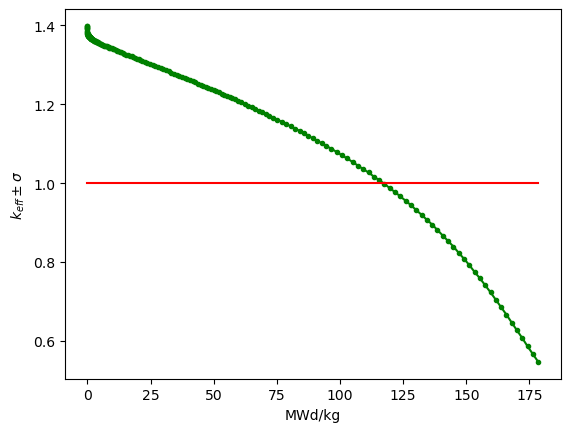

In [36]:
pyplot.plot(time, k[:, 0],color='green',marker='o',markersize=3)
eff=[1]*201
pyplot.plot(time,eff,color='red')
pyplot.xlabel("MWd/kg")
pyplot.ylabel("$k_{eff}\pm \sigma$");

pyplot.show()